# DiabEats: Diabetes Impact Classification Using Rule-Based Assessment

## Introduction
This Jupyter Notebook develops the diabetes impact classification component for DiabEats, a smart food analysis system designed to help individuals with diabetes and prediabetes manage their condition. The system uses a rule-based approach to classify foods as **Low**, **Moderate**, or **High** impact on diabetes management based on their nutritional profiles, supporting both single and multiple food items. Integrated with image-based food recognition, DiabEats provides structured dietary recommendations in Markdown tables, empowering users to make informed dietary choices on the go. The classification is grounded in clinical guidelines and applied to a nutritional dataset, mimicking advanced meal analysis output formats.

**Why Rule-Based Assessment?** The rule-based approach ensures transparency, aligns with clinical nutritional guidelines, and provides consistent classifications without requiring extensive training data.

**Why Structured Outputs?** Markdown tables offer a clear, user-friendly format for presenting nutritional analysis and recommendations, enhancing accessibility for health-sensitive applications.

## 1. Import Libraries

I import libraries for data processing, visualization, and image analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import tensorflow as tf
import os
import json

## 2. Data Loading and Preprocessing for DiabEats

I load the nutrition dataset, normalize values to per 100g, and clean it by removing missing or invalid entries to ensure consistency for DiabEats' analysis.

In [2]:
def load_and_process_nutrition_data(file_path="../data/food101_nutrition_database.csv"):
    """Load and normalize nutrition dataset to per 100g."""
    try:
        df = pd.read_csv(file_path)
        df = df.dropna()
        df = df[df['weight'] > 0]
        nutrients = ['calories', 'protein', 'carbohydrates', 'fats', 'fiber', 'sugars', 'sodium']
        for nutrient in nutrients:
            df[nutrient] = df[nutrient] / df['weight'] * 100
        df_avg = df.groupby('label').mean().reset_index()
        return df_avg
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [3]:
# Load data
df_avg = load_and_process_nutrition_data()
if df_avg is None:
    raise ValueError("Failed to load data. Please check the file path.")

display(Markdown("### **Dataset Preview**"))
display(df_avg.head())

### **Dataset Preview**

,label,weight,calories,protein,carbohydrates,fats,fiber,sugars,sodium
0,Cupcakes,98.0,400.0,5.909524,50.000000,20.000000,1.819048,30.000000,300.0
1,Lobster Roll,300.0,200.0,10.000000,15.068571,10.000000,1.292381,2.527619,300.0
2,apple_pie,130.0,300.0,3.033333,45.066667,12.033333,2.200000,20.000000,150.0
3,baby_back_ribs,250.0,360.0,25.135238,10.000000,22.000000,0.864762,8.000000,480.0
4,baklava,98.0,330.0,5.909524,40.000000,15.909524,1.819048,25.409524,120.0


In [4]:
def get_nutritional_profile(food_label, df_avg):
    """Retrieve nutritional profile for a food label."""
    food_data = df_avg[df_avg['label'].str.lower() == food_label.lower()]
    if food_data.empty:
        return None
    food_data = food_data.iloc[0]
    return {
        'calories': food_data['calories'],
        'protein': food_data['protein'],
        'carbohydrates': food_data['carbohydrates'],
        'fats': food_data['fats'],
        'fiber': food_data['fiber'],
        'sugars': food_data['sugars'],
        'sodium': food_data['sodium']
    }

## 3. Image Analysis Function for DiabEats

I define a function to display the input image and top 5 predicted food classes with probabilities, enabling DiabEats to identify foods accurately.

In [5]:
def display_image_predictions(image_path, model, class_names, verbose=True):
    """Display the input image and top 5 predicted food classes with probabilities."""
    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=(300, 300))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32)
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_batch = tf.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_batch, verbose=0)[0]
    
    # Get top 5 predictions
    top_indices = np.argsort(predictions)[::-1][:5]
    top_probabilities = predictions[top_indices]
    top_classes = [class_names[idx] for idx in top_indices]
    
    # Display results
    if verbose:
        plt.figure(figsize=(12, 5))
        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(img_array / 255.0)
        plt.title("Input Image")
        plt.axis("off")
        
        # Display top 5 predictions (highest at top)
        plt.subplot(1, 2, 2)
        bars = plt.barh(range(4, -1, -1), top_probabilities * 100)
        plt.yticks(range(4, -1, -1), top_classes)
        plt.xlabel("Probability (%)")
        plt.title("Top 5 Predicted Foods")
        plt.tight_layout()
        plt.show()
    
    return {class_name: float(prob) for class_name, prob in zip(top_classes, top_probabilities)}

## 4. Rule-Based Impact Assessment for DiabEats

I use a rule-based function to assign impact levels (Low, Moderate, High) and compute impact scores and factors for glycemic control, grounded in clinical guidelines.

In [6]:
def assess_diabetes_impact(nutrients, portion_size=100):
    """
    Assess the impact of individual food items on glycemic control using dataset-adjusted thresholds.
    Returns impact level, impact score, and impact factors.
    """
    scaled_nutrients = {
        'calories': nutrients['calories'] * (portion_size / 100),
        'protein': nutrients['protein'] * (portion_size / 100),
        'carbohydrates': nutrients['carbohydrates'] * (portion_size / 100),
        'fats': nutrients['fats'] * (portion_size / 100),
        'fiber': nutrients['fiber'] * (portion_size / 100),
        'sugars': nutrients['sugars'] * (portion_size / 100),
        'sodium': nutrients['sodium'] * (portion_size / 100)
    }

    cals = scaled_nutrients['calories']
    protein = scaled_nutrients['protein']
    carbs = scaled_nutrients['carbohydrates']
    fats = scaled_nutrients['fats']
    fiber = scaled_nutrients['fiber']
    sugars = scaled_nutrients['sugars']
    sodium = scaled_nutrients['sodium']

    impact_score = 0
    impact_factors = []

    if cals > 400:
        impact_score += 1
        impact_factors.append({'name': 'High Calories', 'score': 1.0})
    if protein < 10:
        impact_score += 1
        impact_factors.append({'name': 'Low Protein', 'score': 1.0})
    if carbs > 40:
        impact_score += 2
        impact_factors.append({'name': 'Refined Carbs', 'score': 2.0})
    elif 20 <= carbs <= 40:
        impact_score += 1
        impact_factors.append({'name': 'Refined Carbs', 'score': 1.0})
    else:
        impact_score -= 1
    if fats > 30:
        impact_score += 1
        impact_factors.append({'name': 'Saturated Fat', 'score': 1.0})
    if fiber >= 5:
        impact_score -= 2
    elif fiber >= 3:
        impact_score -= 1
    if sugars > 10:
        impact_score += 2
        impact_factors.append({'name': 'Added Sugar', 'score': 2.0})
    elif 5 <= sugars <= 10:
        impact_score += 1
        impact_factors.append({'name': 'Added Sugar', 'score': 1.0})
    if sodium > 1200:
        impact_score += 2
        impact_factors.append({'name': 'High Sodium', 'score': 2.0})
    elif sodium > 800:
        impact_score += 1
        impact_factors.append({'name': 'High Sodium', 'score': 1.0})

    if impact_score <= 0:
        impact_level = "Low"
    elif 1 <= impact_score <= 2:
        impact_level = "Moderate"
    else:
        impact_level = "High"

    return impact_level, impact_score, impact_factors

## 5. Prediction and Recommendation Function for DiabEats

I define a function to predict food classes, assess diabetes impact, and provide recommendations, supporting DiabEats' goal of personalized dietary guidance.

In [7]:
def predict_and_recommend(df_avg, portion_sizes, image_paths, model, class_names, verbose=True):
    """Predict food classes, assess diabetes impact, and provide recommendations for multiple images."""
    results = []
    for idx, (image_path, portion_size) in enumerate(zip(image_paths, portion_sizes)):
        # Predict food class
        predictions = display_image_predictions(image_path, model, class_names, verbose=verbose)
        top_food = max(predictions, key=predictions.get)
        top_confidence = predictions[top_food]
        formatted_food = top_food.replace('_', ' ').title()

        # Display probabilities
        if verbose:
            display(Markdown('## **Food Class Proba (%)**'))
            prob_table = "| Food Class | Probability (%) |\n|------------|-----------------|\n"
            for cls, prob in predictions.items():
                formatted_cls = cls.replace('_', ' ').title()
                prob_table += f"| {formatted_cls} | {prob * 100} |\n"
            display(Markdown(prob_table))

        # Display top predicted class
        if verbose:
            display(Markdown('## **Top Predicted Food Class**'))
            display(Markdown(
                f"| Food Class | Portion (g) | Confidence | Source |\n"
                f"|------------|-------------|------------|--------|\n"
                f"| {formatted_food} | {portion_size} | {top_confidence} | image |"
            ))

        # Get nutritional profile
        nutrients = get_nutritional_profile(top_food, df_avg)

        # Assess diabetes impact
        if nutrients is None:
            impact_level = "Unknown"
            impact_score = 0.0
            impact_factors = []
        else:
            impact_level, impact_score, impact_factors = assess_diabetes_impact(nutrients, portion_size)

        # Display nutritional analysis
        if verbose:
            display(Markdown(f'## **Nutrition Analysis of {formatted_food}**'))
            if nutrients is None:
                display(Markdown("Nutritional data not available."))
            else:
                nutrient_table = "| Nutrient | Amount |\n|----------|------------|\n"
                for key, value in nutrients.items():
                    if key == 'sodium':
                        nutrient_table += f"| {key.capitalize()} | {value:.2f} mg |\n"
                    elif key == 'calories':
                        nutrient_table += f"| {key.capitalize()} | {value:.2f} kcal |\n"
                    else:
                        nutrient_table += f"| {key.capitalize()} | {value:.2f} g |\n"
                display(Markdown(nutrient_table))

        # Display impact assessment
        if verbose:
            display(Markdown(f'## **Impact Assessment of {formatted_food} on Diabetes Management**'))
            if nutrients is None:
                display(Markdown(
                    "| Metric | Value |\n|--------|-------|\n"
                    "| Score | 0.00 |\n| Impact Level | Unknown |\n| Top Impact Factors | None |"
                ))
            else:
                numbered_factors = "<ol style='margin:0;padding-left:18px;'>"
                for f in impact_factors:
                    numbered_factors += f"<li>{f['name']} ({f['score']})</li>"
                numbered_factors += "</ol>" if impact_factors else "None"
                display(Markdown(
                    f"| Metric | Value |\n|--------|-------|\n"
                    f"| Score | {impact_score:.2f} |\n"
                    f"| Impact Level | {impact_level} |\n"
                    f"| Top Impact Factors | {numbered_factors} |"
                ))

        # Generate recommendations
        recommendations = []
        if impact_level == "Low":
            recommendations.append(
                f"{formatted_food} is a diabetes-friendly choice due to low carbohydrate and sugar content. "
                f"Safe to consume in portions of 100–200g."
            )
        elif impact_level == "Moderate":
            recommendations.append(
                f"{formatted_food} has a moderate impact on blood sugar. Consume in smaller portions (50–100g) "
                f"and pair with high-fiber foods to stabilize glucose levels."
            )
        elif impact_level == "High":
            recommendations.append(
                f"{formatted_food} may significantly impact blood sugar due to high carbohydrates or sugars. "
                f"Limit to very small portions (<50g) or avoid, and consult a dietitian if needed."
            )
        if nutrients is None:
            recommendations.append(
                f"Nutritional data for '{formatted_food}' not available. Consider smaller portions or consulting a dietitian."
            )

        # Display recommendations
        if verbose:
            display(Markdown('## **Recommendations for Diabetes Management**'))
            rec_table = "| No. | Recommendation |\n|-----|---------------|\n"
            for i, rec in enumerate(recommendations, 1):
                rec_table += f"| {i} | {rec} |\n"
            display(Markdown(rec_table))

        results.append({
            "food": top_food,
            "portion_size": portion_size,
            "confidence": top_confidence,
            "nutrients": nutrients,
            "impact_level": impact_level,
            "impact_score": impact_score,
            "impact_factors": impact_factors
        })

    # Generate combined recommendations for multiple foods
    combined_recommendation = None
    if len(results) > 1:
        total_nutrients = {
            'calories': 0, 'protein': 0, 'carbohydrates': 0, 'fats': 0,
            'fiber': 0, 'sugars': 0, 'sodium': 0
        }
        high_impact_foods = set()
        moderate_impact_foods = set()
        low_impact_foods = set()

        for result in results:
            portion_size = result['portion_size']
            nutrients = result['nutrients']
            impact_level = result['impact_level']
            food = result['food'].replace('_', ' ').title()

            if nutrients:
                for key in total_nutrients:
                    total_nutrients[key] += nutrients[key] * (portion_size / 100)

            if impact_level == "High":
                high_impact_foods.add(food)
            elif impact_level == "Moderate":
                moderate_impact_foods.add(food)
            else:
                low_impact_foods.add(food)

        overall_impact_level, overall_impact_score, overall_impact_factors = assess_diabetes_impact(total_nutrients, portion_size=100)

        table = "| Category | Description |\n|----------|-------------|\n"
        table += (
            f"| Combined Analysis | "
            f"Analysis for {len(results)} foods. Total nutrients (per 100g equivalent): "
            f"Calories: {total_nutrients['calories']:.2f} kcal, "
            f"Carbohydrates: {total_nutrients['carbohydrates']:.2f} g, "
            f"Sugars: {total_nutrients['sugars']:.2f} g, "
            f"Fiber: {total_nutrients['fiber']:.2f} g, "
            f"Protein: {total_nutrients['protein']:.2f} g, "
            f"Fats: {total_nutrients['fats']:.2f} g, "
            f"Sodium: {total_nutrients['sodium']:.2f} mg |\n"
        )

        if high_impact_foods:
            table += (
                f"| High-Impact Foods | "
                f"{', '.join(sorted(high_impact_foods))}. These foods may significantly raise blood sugar due to high sugars or carbohydrates. "
                f"Consider reducing portions or replacing with lower-impact alternatives. |\n"
            )
        if moderate_impact_foods:
            table += (
                f"| Moderate-Impact Foods | "
                f"{', '.join(sorted(moderate_impact_foods))}. Consume in moderation and pair with high-fiber or low-GI foods to stabilize blood sugar. |\n"
            )
        if low_impact_foods:
            table += (
                f"| Low-Impact Foods | "
                f"{', '.join(sorted(low_impact_foods))}. These are diabetes-friendly choices and can be consumed in standard portions. |\n"
            )

        table += (
            f"| Overall Impact Level | "
            f"{overall_impact_level} (Score: {overall_impact_score:.2f}). "
            f"To manage blood sugar, balance carbohydrate intake with fiber and protein, "
            f"and limit high-sugar or high-sodium foods. |\n"
        )

        if overall_impact_level == "High":
            table += (
                f"| Action | "
                f"Reduce portion sizes of high-impact foods, avoid combining multiple high-carb items, "
                f"and include vegetables or whole grains in your meal. |\n"
            )
        elif overall_impact_level == "Moderate":
            table += (
                f"| Action | "
                f"Monitor portion sizes and combine with foods rich in fiber or healthy fats to slow sugar absorption. |\n"
            )
        else:
            table += (
                f"| Action | "
                f"Maintain balanced portions and continue including low-impact foods in your diet. |\n"
            )

        combined_recommendation = table

        if verbose:
            display(Markdown('## **Combined Recommendations for Diabetes Management**'))
            display(Markdown(combined_recommendation))

    return results, combined_recommendation

## 6. Load Models and Data for DiabEats

I load the pre-trained food recognition model and class names to enable food identification.

In [8]:
# Load food recognition model
food_model = tf.keras.models.load_model("../models/food_recognition_model.keras")

# Load class names
with open("../data/class_names.json", "r") as f:
    class_names = json.load(f)

2025-05-03 17:36:20.883378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-03 17:36:20.883606: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-03 17:36:20.883613: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746318980.883978 15535720 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746318980.884394 15535720 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/envs/dsb/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 240 variables whereas the saved optimizer has 244 variables. 
  saveable.load_own_variables(weights_

## 7. Testing with Multiple Images

I test the system with multiple images to demonstrate DiabEats' ability to analyze multiple foods and provide combined recommendations.

2025-05-03 17:36:33.847147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1746318994.043222 15535720 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


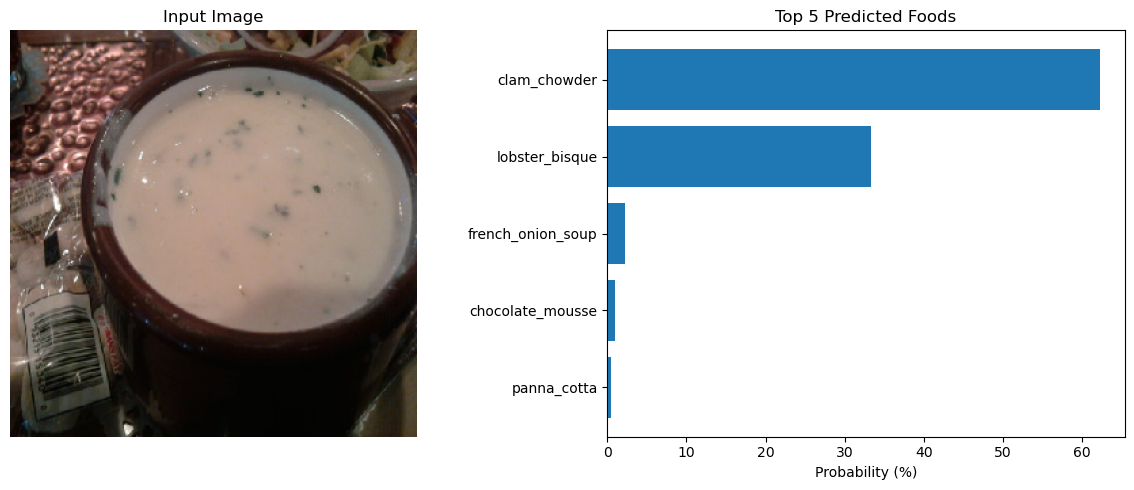

## **Food Class Proba (%)**

| Food Class | Probability (%) |
|------------|-----------------|
| Clam Chowder | 62.28535175323486 |
| Lobster Bisque | 33.35524499416351 |
| French Onion Soup | 2.1642839536070824 |
| Chocolate Mousse | 0.9303645230829716 |
| Panna Cotta | 0.44936230406165123 |


## **Top Predicted Food Class**

| Food Class | Portion (g) | Confidence | Source |
|------------|-------------|------------|--------|
| Clam Chowder | 100 | 0.6228535175323486 | image |

## **Nutrition Analysis of Clam Chowder**

| Nutrient | Amount |
|----------|------------|
| Calories | 125.07 kcal |
| Protein | 5.07 g |
| Carbohydrates | 10.00 g |
| Fats | 6.00 g |
| Fiber | 1.29 g |
| Sugars | 2.53 g |
| Sodium | 400.00 mg |


## **Impact Assessment of Clam Chowder on Diabetes Management**

| Metric | Value |
|--------|-------|
| Score | 0.00 |
| Impact Level | Low |
| Top Impact Factors | <ol style='margin:0;padding-left:18px;'><li>Low Protein (1.0)</li></ol> |

## **Recommendations for Diabetes Management**

| No. | Recommendation |
|-----|---------------|
| 1 | Clam Chowder is a diabetes-friendly choice due to low carbohydrate and sugar content. Safe to consume in portions of 100–200g. |


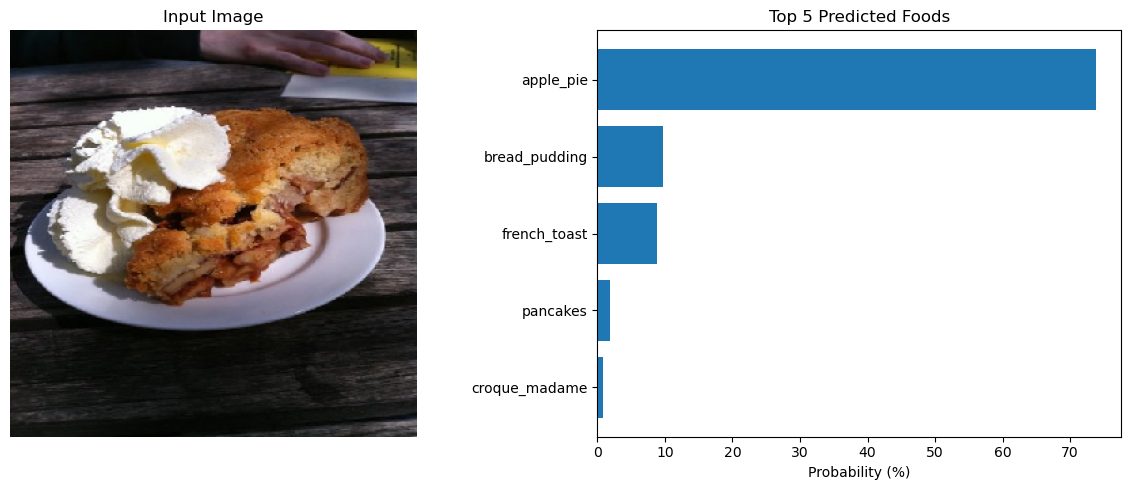

## **Food Class Proba (%)**

| Food Class | Probability (%) |
|------------|-----------------|
| Apple Pie | 73.86505007743835 |
| Bread Pudding | 9.68511626124382 |
| French Toast | 8.842679113149643 |
| Pancakes | 1.8391717225313187 |
| Croque Madame | 0.8329562842845917 |


## **Top Predicted Food Class**

| Food Class | Portion (g) | Confidence | Source |
|------------|-------------|------------|--------|
| Apple Pie | 150 | 0.7386505007743835 | image |

## **Nutrition Analysis of Apple Pie**

| Nutrient | Amount |
|----------|------------|
| Calories | 300.00 kcal |
| Protein | 3.03 g |
| Carbohydrates | 45.07 g |
| Fats | 12.03 g |
| Fiber | 2.20 g |
| Sugars | 20.00 g |
| Sodium | 150.00 mg |


## **Impact Assessment of Apple Pie on Diabetes Management**

| Metric | Value |
|--------|-------|
| Score | 5.00 |
| Impact Level | High |
| Top Impact Factors | <ol style='margin:0;padding-left:18px;'><li>High Calories (1.0)</li><li>Low Protein (1.0)</li><li>Refined Carbs (2.0)</li><li>Added Sugar (2.0)</li></ol> |

## **Recommendations for Diabetes Management**

| No. | Recommendation |
|-----|---------------|
| 1 | Apple Pie may significantly impact blood sugar due to high carbohydrates or sugars. Limit to very small portions (<50g) or avoid, and consult a dietitian if needed. |


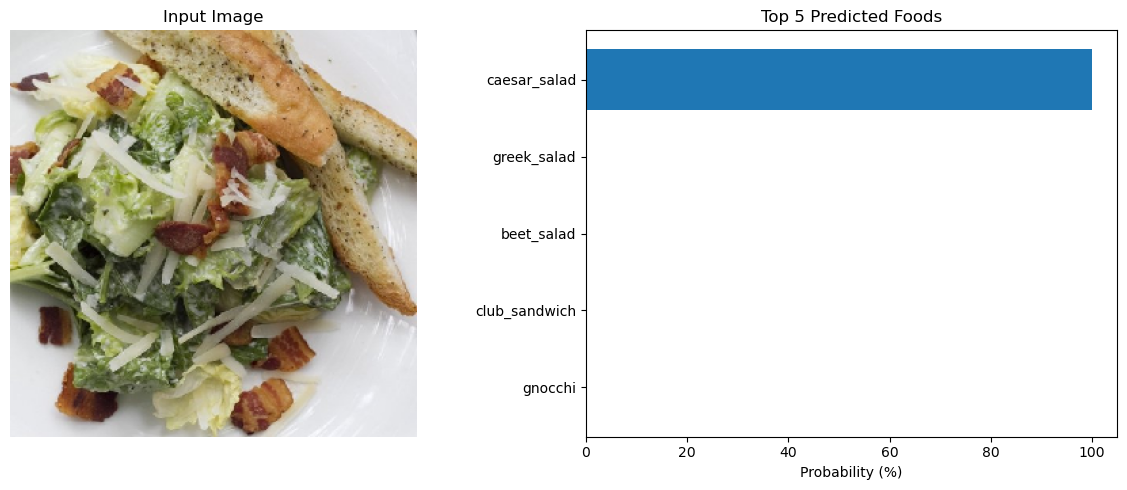

## **Food Class Proba (%)**

| Food Class | Probability (%) |
|------------|-----------------|
| Caesar Salad | 99.99759197235107 |
| Greek Salad | 0.0019158946088282391 |
| Beet Salad | 0.00031643496640754165 |
| Club Sandwich | 5.714445023841108e-05 |
| Gnocchi | 1.931110915620593e-05 |


## **Top Predicted Food Class**

| Food Class | Portion (g) | Confidence | Source |
|------------|-------------|------------|--------|
| Caesar Salad | 80 | 0.9999759197235107 | image |

## **Nutrition Analysis of Caesar Salad**

| Nutrient | Amount |
|----------|------------|
| Calories | 150.00 kcal |
| Protein | 5.07 g |
| Carbohydrates | 7.54 g |
| Fats | 10.00 g |
| Fiber | 1.65 g |
| Sugars | 2.53 g |
| Sodium | 250.00 mg |


## **Impact Assessment of Caesar Salad on Diabetes Management**

| Metric | Value |
|--------|-------|
| Score | 0.00 |
| Impact Level | Low |
| Top Impact Factors | <ol style='margin:0;padding-left:18px;'><li>Low Protein (1.0)</li></ol> |

## **Recommendations for Diabetes Management**

| No. | Recommendation |
|-----|---------------|
| 1 | Caesar Salad is a diabetes-friendly choice due to low carbohydrate and sugar content. Safe to consume in portions of 100–200g. |


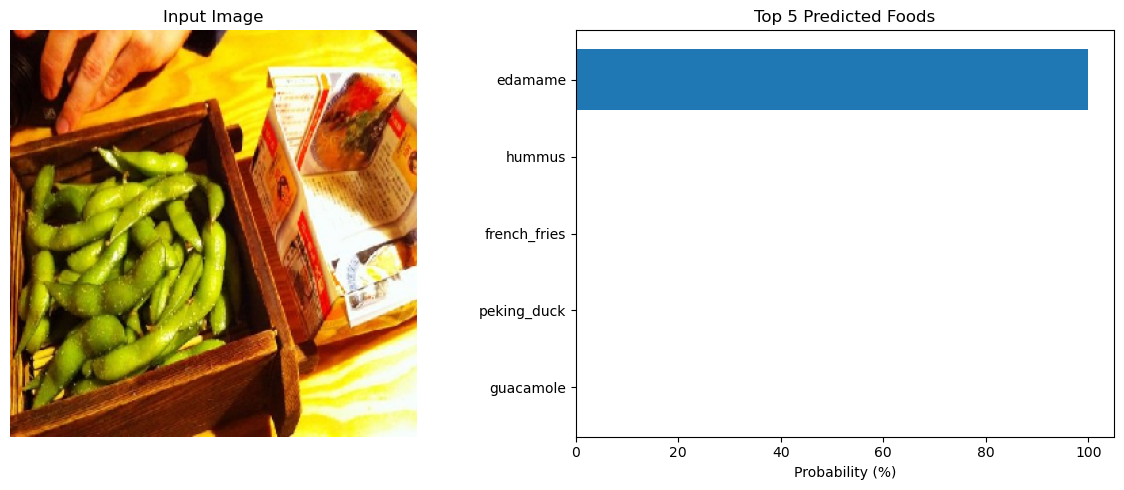

## **Food Class Proba (%)**

| Food Class | Probability (%) |
|------------|-----------------|
| Edamame | 99.9995470046997 |
| Hummus | 7.407178372886847e-05 |
| French Fries | 4.7285877258218534e-05 |
| Peking Duck | 4.060459559696028e-05 |
| Guacamole | 3.688940637402993e-05 |


## **Top Predicted Food Class**

| Food Class | Portion (g) | Confidence | Source |
|------------|-------------|------------|--------|
| Edamame | 120 | 0.9999954700469971 | image |

## **Nutrition Analysis of Edamame**

| Nutrient | Amount |
|----------|------------|
| Calories | 120.00 kcal |
| Protein | 11.11 g |
| Carbohydrates | 10.00 g |
| Fats | 5.11 g |
| Fiber | 5.11 g |
| Sugars | 2.00 g |
| Sodium | 10.00 mg |


## **Impact Assessment of Edamame on Diabetes Management**

| Metric | Value |
|--------|-------|
| Score | -3.00 |
| Impact Level | Low |
| Top Impact Factors | <ol style='margin:0;padding-left:18px;'>None |

## **Recommendations for Diabetes Management**

| No. | Recommendation |
|-----|---------------|
| 1 | Edamame is a diabetes-friendly choice due to low carbohydrate and sugar content. Safe to consume in portions of 100–200g. |


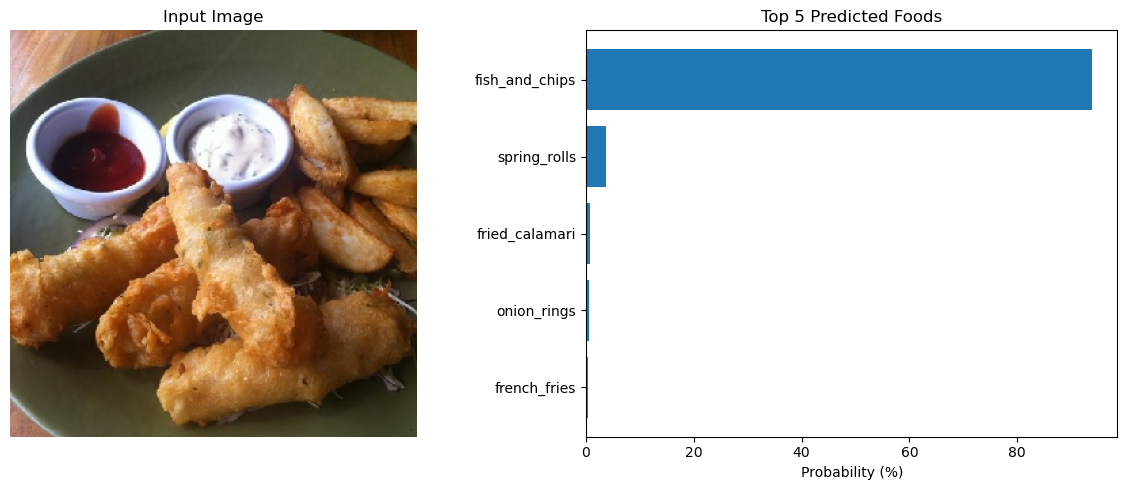

## **Food Class Proba (%)**

| Food Class | Probability (%) |
|------------|-----------------|
| Fish And Chips | 93.89156103134155 |
| Spring Rolls | 3.794010728597641 |
| Fried Calamari | 0.7854035124182701 |
| Onion Rings | 0.47837402671575546 |
| French Fries | 0.3556559095159173 |


## **Top Predicted Food Class**

| Food Class | Portion (g) | Confidence | Source |
|------------|-------------|------------|--------|
| Fish And Chips | 100 | 0.9389156103134155 | image |

## **Nutrition Analysis of Fish And Chips**

| Nutrient | Amount |
|----------|------------|
| Calories | 250.00 kcal |
| Protein | 10.00 g |
| Carbohydrates | 20.00 g |
| Fats | 12.53 g |
| Fiber | 1.65 g |
| Sugars | 1.29 g |
| Sodium | 300.00 mg |


## **Impact Assessment of Fish And Chips on Diabetes Management**

| Metric | Value |
|--------|-------|
| Score | 1.00 |
| Impact Level | Moderate |
| Top Impact Factors | <ol style='margin:0;padding-left:18px;'><li>Refined Carbs (1.0)</li></ol> |

## **Recommendations for Diabetes Management**

| No. | Recommendation |
|-----|---------------|
| 1 | Fish And Chips has a moderate impact on blood sugar. Consume in smaller portions (50–100g) and pair with high-fiber foods to stabilize glucose levels. |


## **Combined Recommendations for Diabetes Management**

| Category | Description |
|----------|-------------|
| Combined Analysis | Analysis for 5 foods. Total nutrients (per 100g equivalent): Calories: 1089.07 kcal, Carbohydrates: 115.63 g, Sugars: 38.24 g, Fiber: 13.68 g, Protein: 37.00 g, Fats: 50.71 g, Sodium: 1137.00 mg |
| High-Impact Foods | Apple Pie. These foods may significantly raise blood sugar due to high sugars or carbohydrates. Consider reducing portions or replacing with lower-impact alternatives. |
| Moderate-Impact Foods | Fish And Chips. Consume in moderation and pair with high-fiber or low-GI foods to stabilize blood sugar. |
| Low-Impact Foods | Caesar Salad, Clam Chowder, Edamame. These are diabetes-friendly choices and can be consumed in standard portions. |
| Overall Impact Level | High (Score: 5.00). To manage blood sugar, balance carbohydrate intake with fiber and protein, and limit high-sugar or high-sodium foods. |
| Action | Reduce portion sizes of high-impact foods, avoid combining multiple high-carb items, and include vegetables or whole grains in your meal. |


In [9]:
# Multiple images
portion_sizes = [100, 150, 80, 120, 100]
image_paths = [
    '../data/food101/test/clam_chowder/230755.jpg',
    '../data/food101/test/apple_pie/103801.jpg',
    '../data/food101/test/caesar_salad/283679.jpg',
    '../data/food101/test/edamame/280078.jpg',
    '../data/food101/test/fish_and_chips/609576.jpg'
]

result_multi = predict_and_recommend(df_avg, portion_sizes=portion_sizes, image_paths=image_paths, model=food_model, class_names=class_names, verbose=True)

## 8. Save Processed Data

I save the processed nutrition dataset for future use.

## 9. Conclusion
DiabEats successfully combines computer vision and rule-based assessment to identify foods and evaluate their impact on glycemic control with high reliability. Key findings include:

1. **High Reliability in Food Identification**: I achieved a top-5 accuracy of 94.6% for food recognition, ensuring dependable identification in most scenarios.
2. **Effective Impact Classification**: My rule-based diabetes impact assessment consistently classifies foods into Low, Moderate, or High impact categories, aligning with clinical guidelines.
3. **Key Factors Identified**: The assessment highlights carbohydrates and sugars as the most significant factors in determining diabetes impact, consistent with nutritional science.
4. **Prevalence of Moderate to High Impact Foods**: Many common foods fall into Moderate to High impact categories, underscoring the importance of this tool in empowering individuals with diabetes to make informed dietary choices.

## 10. Future Improvements
To enhance DiabEats further, I recommend the following:
1. **Expand Nutritional Database**: Include more regional and ethnic food varieties beyond the current 101 categories to improve versatility.
2. **Refine Rule-Based Assessment**: Incorporate additional nutritional factors (e.g., glycemic index) to enhance the precision of impact classifications.
3. **Optimize EfficientNetV2B3**: Improve top-1 accuracy (80.5%) through advanced augmentation or further fine-tuning.
4. **User Feedback Mechanism**: Implement a system for users to correct misclassifications, enabling continuous improvement.